Para llevar a cabo todo esto, necesitarás el archivo de datos imdb_anime.csv, que contiene las siguientes columnas: ● Title: Nombre de la animación ● Genre: Género(s) bajo el cual cae la animación, por ejemplo, Acción, Aventura, etc. ● User Rating: IMDb calificación de usuarios sobre 10. ● Number of Votes: Total de usuarios de IMDb que han calificado la animación. ● Runtime: Duración de la animación en minutos. ● Year: Año en que se estrenó o comenzó a emitirse la animación. ● Summary: Un resumen breve o completo de la trama de la animación. Resúmenes completos se obtienen cuando están disponibles. ● Stars: Lista de actores principales o actores de voz involucrados en la animación. ● Certificate: Certificación de la animación, por ejemplo, PG, PG-13, etc. ● Metascore: Calificación de Metascore, si disponible, que es una puntuación agregada de varios críticos. ● Gross: Ganancias brutas o recaudación en taquilla de la animación. ● Episode: Indicador binario si la lista es para un episodio de una serie (1 para sí, 0 para no). ● Episode Title: Título del episodio si la lista es para un episodio; de lo contrario, será None (Ninguno). )))

In [1]:
#Importamos las librerias necesarias
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
#cargamos archivo y revisamos los datos
df=pd.read_excel('imdb_anime.xlsx')
print(df.shape)
df.head(5)

(45717, 13)


,Title,Genre,User Rating,Number of Votes,Runtime,Year,Summary,Stars,Certificate,Metascore,Gross,Episode,Episode Title
0,One Piece,"Animation, Action, Adventure",8.9,187689,24 min,(1999– ),Follows the adventures of Monkey D. Luffy and ...,"Mayumi Tanaka,Laurent Vernin,Akemi Okamura,Ton...",TV-14,NaN,187689,0,NaN
1,Teenage Mutant Ninja Turtles: Mutant Mayhem,"Animation, Action, Adventure",7.4,28895,99 min,-2023,The film follows the Turtle brothers as they w...,NaN,PG,74,28895,0,NaN
2,The Super Mario Bros. Movie,"Animation, Adventure, Comedy",7.1,189108,92 min,-2023,A plumber named Mario travels through an under...,NaN,PG,46,189108,0,NaN
3,Attack on Titan,"Animation, Action, Adventure",9.1,434457,24 min,(2013–2023),After his hometown is destroyed and his mother...,"Josh Grelle,Bryce Papenbrook,Yûki Kaji,Yui Ish...",TV-MA,NaN,434457,0,NaN
4,Jujutsu Kaisen,"Animation, Action, Adventure",8.5,82909,24 min,(2020– ),A boy swallows a cursed talisman - the finger ...,"Junya Enoki,Yûichi Nakamura,Adam McArthur,Yuma...",TV-MA,NaN,82909,0,NaN


In [3]:
# Contar los valores nulos por columna
nulos_por_columna = df.isnull().sum()

print("Valores nulos por columna:")
print(nulos_por_columna)

Valores nulos por columna:
Title                  0
Genre                  0
User Rating        20708
Number of Votes    20708
Runtime            13168
Year                 126
Summary            22170
Stars              32041
Certificate        17023
Metascore          45376
Gross              20708
Episode                0
Episode Title      10807
dtype: int64


Las columnas certificate, episode y stars no aportan nada importante para el estudio. y numero de votos y gross son columnas duplicadas, se eliminara gross

In [4]:
selected = df[['Number of Votes','Gross']]
selected.head(-5)

,Number of Votes,Gross
0,187689,187689
1,28895,28895
2,189108,189108
3,434457,434457
4,82909,82909
...,...,...
45707,3464,3464
45708,3787,3787
45709,3456,3456
45710,3401,3401


In [5]:
#columns_to_drop = ['Stars','Certificate','Episode','Gross']
#df = df.drop(columns=columns_to_drop)

In [6]:
df.dtypes

Title              object
Genre              object
User Rating        object
Number of Votes    object
Runtime            object
Year               object
Summary            object
Stars              object
Certificate        object
Metascore          object
Gross              object
Episode            object
Episode Title      object
dtype: object

Para el analisis exploratorio inicial hay que transformar algunas variables

Transformacion de datos

In [7]:
#vamos eliminar la columna year separandola en dos columnas Year_start y year_end
import re
#covertimos year a str
df['Year'] = df['Year'].astype(str)

# Crear columnas Year_start y Year_end con valores iniciales
df['Year_start'] = None
df['Year_end'] = None

# Iterar sobre la fila Year del DataFrame
for index, row in df.iterrows():
    if row['Year'].startswith('('):
        years = re.findall(r'\d{4}', row['Year'])
        df.at[index, 'Year_start'] = years[0] if years else None
        df.at[index, 'Year_end'] = years[1] if len(years) > 1 else "2024"
    elif row['Year'].startswith('-'):
        df.at[index, 'Year_start'] = row['Year'][1:]
        df.at[index, 'Year_end'] = row['Year'][1:]
    else:
        df.at[index, 'Year_start'] = row['Year'][1:-3]
        df.at[index, 'Year_end'] = "2023"


In [8]:
# Convertir las columnas a los tipos de datos apropiados
df['User Rating'] = pd.to_numeric(df['User Rating'], errors='coerce')
df['Number of Votes'] = pd.to_numeric(df['Number of Votes'], errors='coerce')
df['Title'] = df['Title'].astype(str)
df['Year_start'] = df['Year_start'].astype(str)
df['Genre'] = df['Genre'].astype(str)
df['Runtime'] = df['Runtime'].astype(str)
df['Runtime'] = df['Runtime'].str.extract('(\d+)').astype(float)
df['Metascore'] = pd.to_numeric(df['Metascore'], errors='coerce')
df['Year_start'] = pd.to_datetime(df['Year_start'], format='%Y',errors='coerce')
df['Year_end'] = pd.to_datetime(df['Year_end'], format='%Y',errors='coerce')
df['Episode'] = pd.to_numeric(df['Episode'], errors='coerce')
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')
df['Year'] = pd.to_datetime(df['Year'], format='%Y',errors='coerce')

In [9]:
duplicates = df.columns[df.columns.duplicated()]
if duplicates.any():
    print(f'Hay columnas duplicadas: {", ".join(duplicates)}')
else:
    print('No hay columnas duplicadas.')

No hay columnas duplicadas.


In [10]:
# Contar los valores nulos por columna
nulos_por_columna = df.isnull().sum()

print("Valores nulos por columna:")
print(nulos_por_columna)

Valores nulos por columna:
Title                  0
Genre                  0
User Rating        20709
Number of Votes    20709
Runtime            13169
Year               45717
Summary            22170
Stars              32041
Certificate        17023
Metascore          45377
Gross              20709
Episode                1
Episode Title      10807
Year_start           146
Year_end               0
dtype: int64


In [11]:
# Rellenar valores nulos en 'Episode Title' con "No disponible"
df['Episode Title'].fillna('No disponible', inplace=True)
df['User Rating'].fillna(1, inplace=True)
df['Number of Votes'].fillna(0, inplace=True)
df['Runtime'].fillna(df['Runtime'].mean(), inplace=True)
df['Metascore'].fillna(1, inplace=True)
df=df.dropna(subset=['Year_start'])
df

,Title,Genre,User Rating,Number of Votes,Runtime,Year,Summary,Stars,Certificate,Metascore,Gross,Episode,Episode Title,Year_start,Year_end
0,One Piece,"Animation, Action, Adventure",8.9,187689.0,24.00000,NaT,Follows the adventures of Monkey D. Luffy and ...,"Mayumi Tanaka,Laurent Vernin,Akemi Okamura,Ton...",TV-14,1.0,187689.0,0.0,No disponible,1999-01-01,2024-01-01
1,Teenage Mutant Ninja Turtles: Mutant Mayhem,"Animation, Action, Adventure",7.4,28895.0,99.00000,NaT,The film follows the Turtle brothers as they w...,NaN,PG,74.0,28895.0,0.0,No disponible,2023-01-01,2023-01-01
2,The Super Mario Bros. Movie,"Animation, Adventure, Comedy",7.1,189108.0,92.00000,NaT,A plumber named Mario travels through an under...,NaN,PG,46.0,189108.0,0.0,No disponible,2023-01-01,2023-01-01
3,Attack on Titan,"Animation, Action, Adventure",9.1,434457.0,24.00000,NaT,After his hometown is destroyed and his mother...,"Josh Grelle,Bryce Papenbrook,Yûki Kaji,Yui Ish...",TV-MA,1.0,434457.0,0.0,No disponible,2013-01-01,2023-01-01
4,Jujutsu Kaisen,"Animation, Action, Adventure",8.5,82909.0,24.00000,NaT,A boy swallows a cursed talisman - the finger ...,"Junya Enoki,Yûichi Nakamura,Adam McArthur,Yuma...",TV-MA,1.0,82909.0,0.0,No disponible,2020-01-01,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45712,Demon Slayer: Kimetsu no Yaiba,"Animation, Action, Adventure",7.3,3432.0,24.00000,NaT,Tanjiro heads to his next location southeast; ...,NaN,TV-14,1.0,3432.0,1.0,Tsuzumi Mansion,2019-01-01,2024-01-01
45713,Demon Slayer: Kimetsu no Yaiba,"Animation, Action, Adventure",7.9,3309.0,24.00000,NaT,Tanjiro gets separated from Zenitsu when he en...,NaN,TV-MA,1.0,3309.0,1.0,"The Boar Bares Its Fangs, Zenitsu Sleeps",2019-01-01,2024-01-01
45714,One Piece,"Animation, Action, Adventure",9.4,2743.0,27.38411,NaT,Carrot tells Sanji the news about Pedro. Germa...,"Mayumi Tanaka,Tom Henry,Masako Katsuki,Mami Ko...",TV-14,1.0,2743.0,1.0,Time for Farewell! Pudding's One Last Request!,1999-01-01,2024-01-01
45715,Marmalade Boy,"Animation, Comedy, Drama",1.0,0.0,24.00000,NaT,NaN,"Ogie Banks,Deborah Sale Butler,John DeMita,Ric...",Not Rated,1.0,NaN,1.0,Hijiri naru yoru (ivu nanoni hitori bocchi...),1994-01-01,2005-01-01


In [12]:
df.dtypes

Title                      object
Genre                      object
User Rating               float64
Number of Votes           float64
Runtime                   float64
Year               datetime64[ns]
Summary                    object
Stars                      object
Certificate                object
Metascore                 float64
Gross                     float64
Episode                   float64
Episode Title              object
Year_start         datetime64[ns]
Year_end           datetime64[ns]
dtype: object

In [15]:
df

,Title,Genre,User Rating,Number of Votes,Runtime,Year,Summary,Stars,Certificate,Metascore,Gross,Episode,Episode Title,Year_start,Year_end
0,One Piece,"Animation, Action, Adventure",8.9,187689.0,24.00000,NaT,Follows the adventures of Monkey D. Luffy and ...,"Mayumi Tanaka,Laurent Vernin,Akemi Okamura,Ton...",TV-14,1.0,187689.0,0.0,No disponible,1999-01-01,2024-01-01
1,Teenage Mutant Ninja Turtles: Mutant Mayhem,"Animation, Action, Adventure",7.4,28895.0,99.00000,NaT,The film follows the Turtle brothers as they w...,NaN,PG,74.0,28895.0,0.0,No disponible,2023-01-01,2023-01-01
2,The Super Mario Bros. Movie,"Animation, Adventure, Comedy",7.1,189108.0,92.00000,NaT,A plumber named Mario travels through an under...,NaN,PG,46.0,189108.0,0.0,No disponible,2023-01-01,2023-01-01
3,Attack on Titan,"Animation, Action, Adventure",9.1,434457.0,24.00000,NaT,After his hometown is destroyed and his mother...,"Josh Grelle,Bryce Papenbrook,Yûki Kaji,Yui Ish...",TV-MA,1.0,434457.0,0.0,No disponible,2013-01-01,2023-01-01
4,Jujutsu Kaisen,"Animation, Action, Adventure",8.5,82909.0,24.00000,NaT,A boy swallows a cursed talisman - the finger ...,"Junya Enoki,Yûichi Nakamura,Adam McArthur,Yuma...",TV-MA,1.0,82909.0,0.0,No disponible,2020-01-01,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45712,Demon Slayer: Kimetsu no Yaiba,"Animation, Action, Adventure",7.3,3432.0,24.00000,NaT,Tanjiro heads to his next location southeast; ...,NaN,TV-14,1.0,3432.0,1.0,Tsuzumi Mansion,2019-01-01,2024-01-01
45713,Demon Slayer: Kimetsu no Yaiba,"Animation, Action, Adventure",7.9,3309.0,24.00000,NaT,Tanjiro gets separated from Zenitsu when he en...,NaN,TV-MA,1.0,3309.0,1.0,"The Boar Bares Its Fangs, Zenitsu Sleeps",2019-01-01,2024-01-01
45714,One Piece,"Animation, Action, Adventure",9.4,2743.0,27.38411,NaT,Carrot tells Sanji the news about Pedro. Germa...,"Mayumi Tanaka,Tom Henry,Masako Katsuki,Mami Ko...",TV-14,1.0,2743.0,1.0,Time for Farewell! Pudding's One Last Request!,1999-01-01,2024-01-01
45715,Marmalade Boy,"Animation, Comedy, Drama",1.0,0.0,24.00000,NaT,NaN,"Ogie Banks,Deborah Sale Butler,John DeMita,Ric...",Not Rated,1.0,NaN,1.0,Hijiri naru yoru (ivu nanoni hitori bocchi...),1994-01-01,2005-01-01


In [13]:
# Crear un nuevo DataFrame con las columnas y orden seleccionado
selected_columns = ['Title', 'Genre', 'Episode Title', 'Runtime', 'User Rating','Metascore', 'Number of Votes','Year_start','Year_end']
df2 = df[selected_columns].copy()

# Visualizar el nuevo DataFrame
df2

,Title,Genre,Episode Title,Runtime,User Rating,Metascore,Number of Votes,Year_start,Year_end
0,One Piece,"Animation, Action, Adventure",No disponible,24.00000,8.9,1.0,187689.0,1999-01-01,2024-01-01
1,Teenage Mutant Ninja Turtles: Mutant Mayhem,"Animation, Action, Adventure",No disponible,99.00000,7.4,74.0,28895.0,2023-01-01,2023-01-01
2,The Super Mario Bros. Movie,"Animation, Adventure, Comedy",No disponible,92.00000,7.1,46.0,189108.0,2023-01-01,2023-01-01
3,Attack on Titan,"Animation, Action, Adventure",No disponible,24.00000,9.1,1.0,434457.0,2013-01-01,2023-01-01
4,Jujutsu Kaisen,"Animation, Action, Adventure",No disponible,24.00000,8.5,1.0,82909.0,2020-01-01,2024-01-01
...,...,...,...,...,...,...,...,...,...
45712,Demon Slayer: Kimetsu no Yaiba,"Animation, Action, Adventure",Tsuzumi Mansion,24.00000,7.3,1.0,3432.0,2019-01-01,2024-01-01
45713,Demon Slayer: Kimetsu no Yaiba,"Animation, Action, Adventure","The Boar Bares Its Fangs, Zenitsu Sleeps",24.00000,7.9,1.0,3309.0,2019-01-01,2024-01-01
45714,One Piece,"Animation, Action, Adventure",Time for Farewell! Pudding's One Last Request!,27.38411,9.4,1.0,2743.0,1999-01-01,2024-01-01
45715,Marmalade Boy,"Animation, Comedy, Drama",Hijiri naru yoru (ivu nanoni hitori bocchi...),24.00000,1.0,1.0,0.0,1994-01-01,2005-01-01


Tratamiento de nulos: los nulos de user rating y metascore ,  si son nulos, se sutituiran por la nota minima 1 .Los nulos en numero de votos seran sustituidos por cero. Los nulos en title se rellenaran con "no disponible", la columna runtime no puede tener tiempo 0, porque ningun capitulo o pelicula dura 0min será imputada con la media. Year_star, eliminaremos los nulos

In [16]:
# Contar los valores nulos por columna
nulos_por_columna = df2.isnull().sum()

print("Valores nulos por columna:")
print(nulos_por_columna)

Valores nulos por columna:
Title              0
Genre              0
Episode Title      0
Runtime            0
User Rating        0
Metascore          0
Number of Votes    0
Year_start         0
Year_end           0
dtype: int64


Anlisis exploratorio

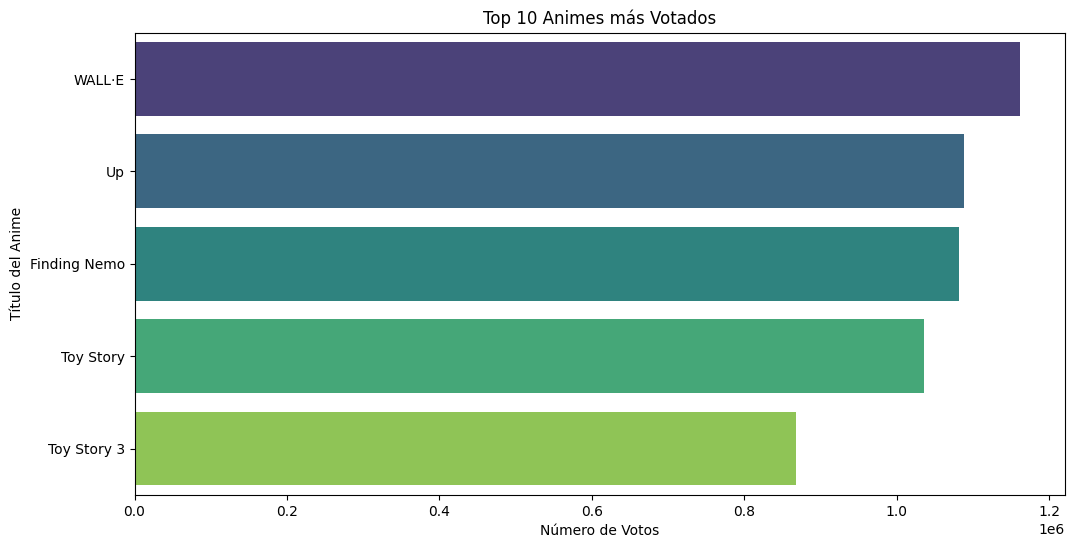

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar los animes por número de votos de mayor a menor
top_voted_animes = df2.sort_values(by='Number of Votes', ascending=False).head(10)

# Gráfico de barras para los 10 animes más votados
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Votes', y='Title', data=top_voted_animes, palette='viridis')
plt.title('Top 10 Animes más Votados')
plt.xlabel('Número de Votos')
plt.ylabel('Título del Anime')
plt.show()


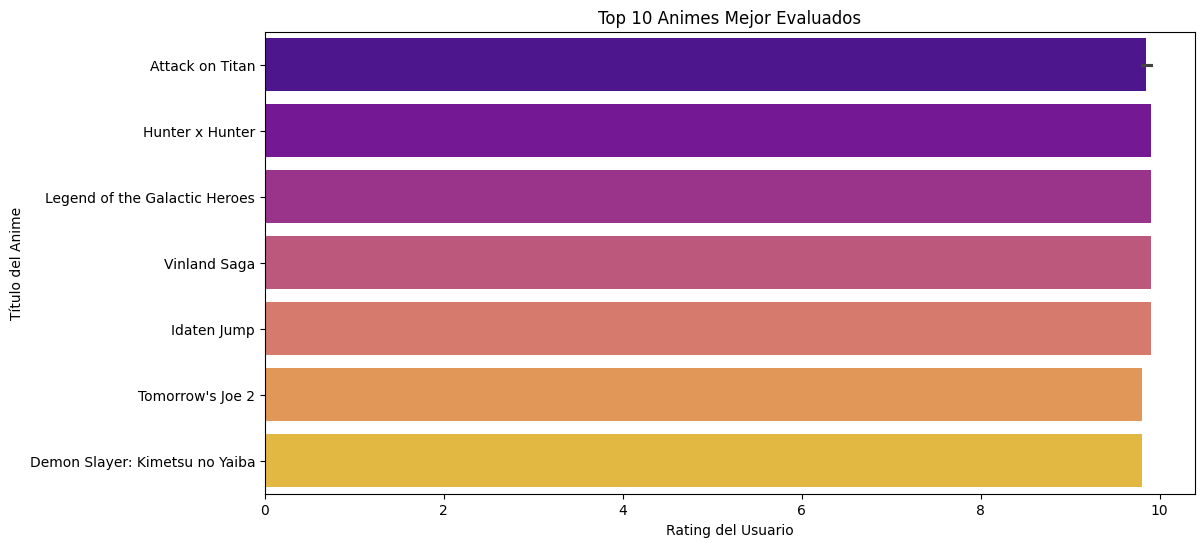

In [18]:
# Ordenar los animes por rating de mayor a menor
top_rated_animes = df2.sort_values(by='User Rating', ascending=False).head(10)

# Gráfico de barras para los 10 animes mejor evaluados
plt.figure(figsize=(12, 6))
sns.barplot(x='User Rating', y='Title', data=top_rated_animes, palette='plasma')
plt.title('Top 10 Animes Mejor Evaluados')
plt.xlabel('Rating del Usuario')
plt.ylabel('Título del Anime')
plt.show()


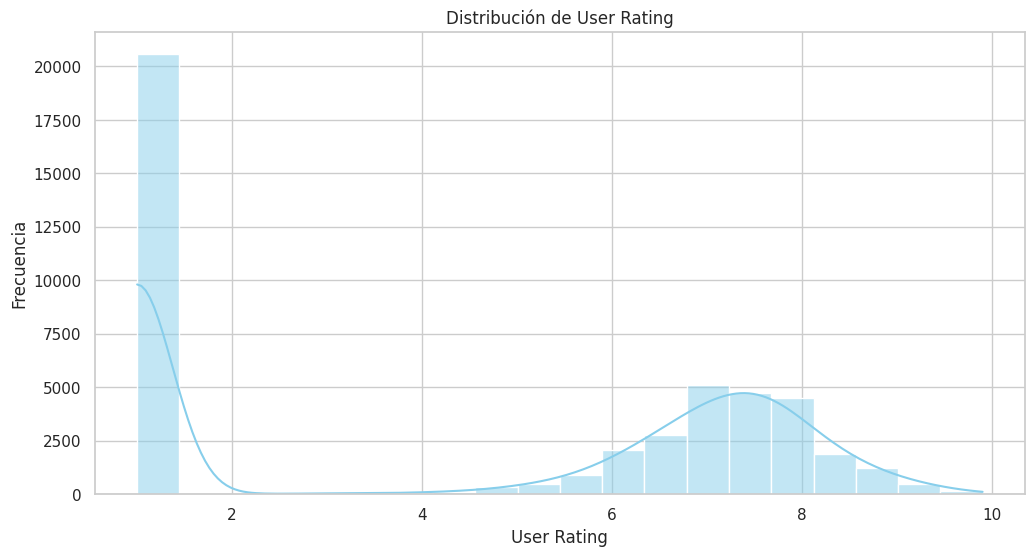

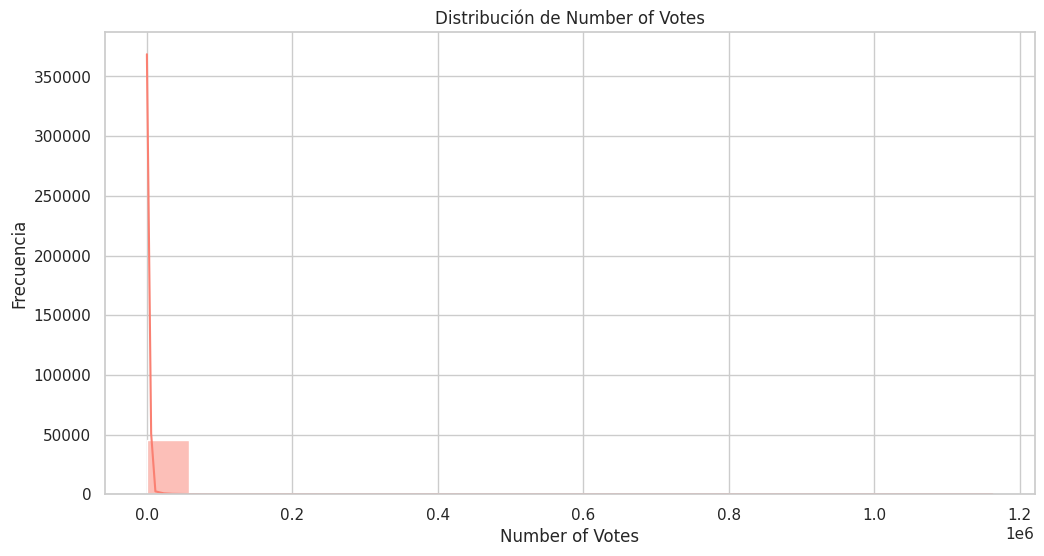

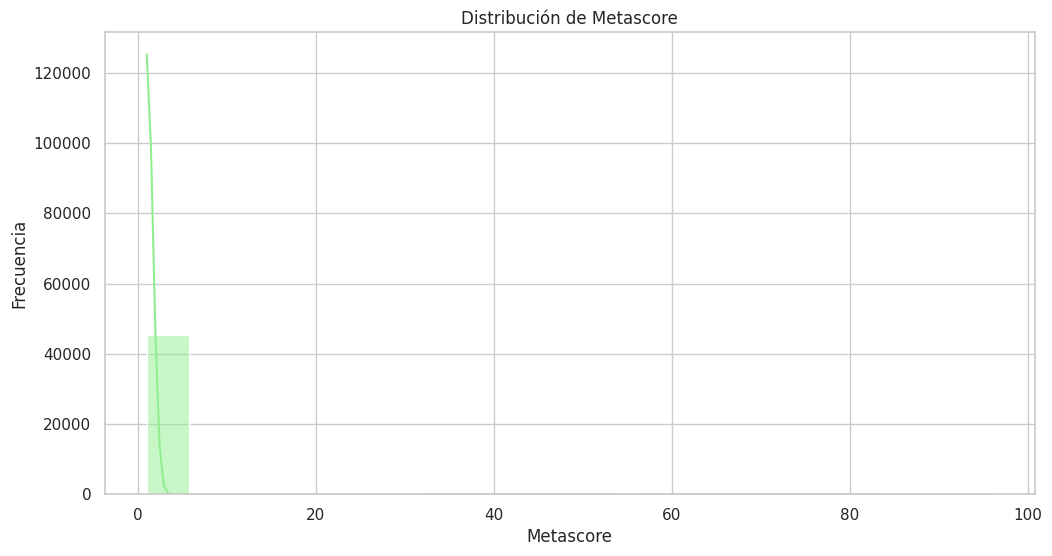

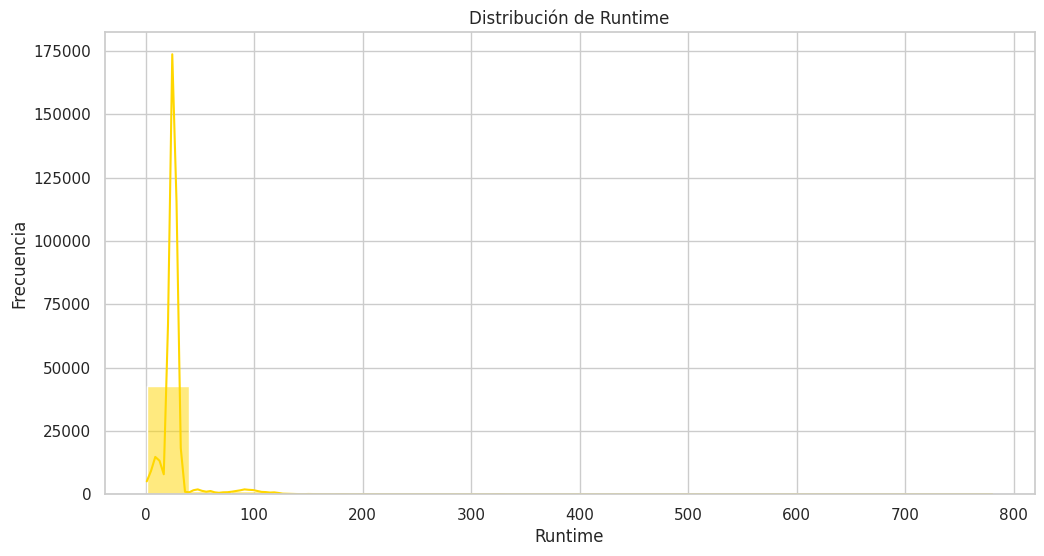

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de distribución para User Rating
plt.figure(figsize=(12, 6))
sns.histplot(df2['User Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribución de User Rating')
plt.xlabel('User Rating')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de distribución para Number of Votes
plt.figure(figsize=(12, 6))
sns.histplot(df2['Number of Votes'], bins=20, kde=True, color='salmon')
plt.title('Distribución de Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de distribución para Metascore
plt.figure(figsize=(12, 6))
sns.histplot(df2['Metascore'], bins=20, kde=True, color='lightgreen')
plt.title('Distribución de Metascore')
plt.xlabel('Metascore')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de distribución para Runtime
plt.figure(figsize=(12, 6))
sns.histplot(df2['Runtime'], bins=20, kde=True, color='gold')
plt.title('Distribución de Runtime')
plt.xlabel('Runtime')
plt.ylabel('Frecuencia')
plt.show()


Revisión de outliers:

In [21]:
df1=df2.copy()

In [22]:
# Seleccionar columnas numéricas para el análisis de outliers
numeric_columns = df1.select_dtypes(include=['float64']).columns

# Calcular el rango intercuartílico (IQR) para cada columna
Q1 = df1[numeric_columns].quantile(0.25)
Q3 = df1[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Filtrar filas que no contienen outliers
df1_nu = df1[~((df1[numeric_columns] < (Q1 - 1.5 * IQR)) | (df1[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Mostrar DataFrame sin outliers
df1_nu

,Title,Genre,Episode Title,Runtime,User Rating,Metascore,Number of Votes,Year_start,Year_end
53,Scott Pilgrim Takes Off,"Animation, Action, Adventure",No disponible,27.38411,1.0,1.0,0.0,2023-01-01,2024-01-01
95,Sonic the Hedgehog 3,"Animation, Action, Adventure",No disponible,27.38411,1.0,1.0,0.0,2024-01-01,2024-01-01
160,Inside Out 2,"Animation, Adventure, Comedy",No disponible,27.38411,1.0,1.0,0.0,2024-01-01,2024-01-01
270,Undead Murder Farce,"Animation, Drama, Fantasy",No disponible,27.38411,7.6,1.0,224.0,2023-01-01,2024-01-01
295,Synduality: Noir,"Animation, Action, Adventure",No disponible,24.00000,7.3,1.0,75.0,2023-01-01,2024-01-01
...,...,...,...,...,...,...,...,...,...
45700,Fighting General Daimos,"Animation, Action, Adventure",Erika Fights Richard,27.38411,1.0,1.0,0.0,1978-01-01,1979-01-01
45701,Fighting General Daimos,"Animation, Action, Adventure",Is Princess Erika A Murderer?,27.38411,1.0,1.0,0.0,1978-01-01,1979-01-01
45702,Boruto: Naruto Next Generations,"Animation, Action, Adventure",Jûgo to juin,27.38411,6.6,1.0,257.0,2017-01-01,2024-01-01
45715,Marmalade Boy,"Animation, Comedy, Drama",Hijiri naru yoru (ivu nanoni hitori bocchi...),24.00000,1.0,1.0,0.0,1994-01-01,2005-01-01


Analisis de correlacion

In [23]:
# Seleccionar solo las columnas numéricas para el análisis de correlación
numeric_columns = df1_nu.select_dtypes(include=['float64']).columns
correlation_matrix = df1_nu[numeric_columns].corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

                  Runtime  User Rating  Metascore  Number of Votes
Runtime          1.000000    -0.165812        NaN         -0.11513
User Rating     -0.165812     1.000000        NaN          0.59754
Metascore             NaN          NaN        NaN              NaN
Number of Votes -0.115130     0.597540        NaN          1.00000


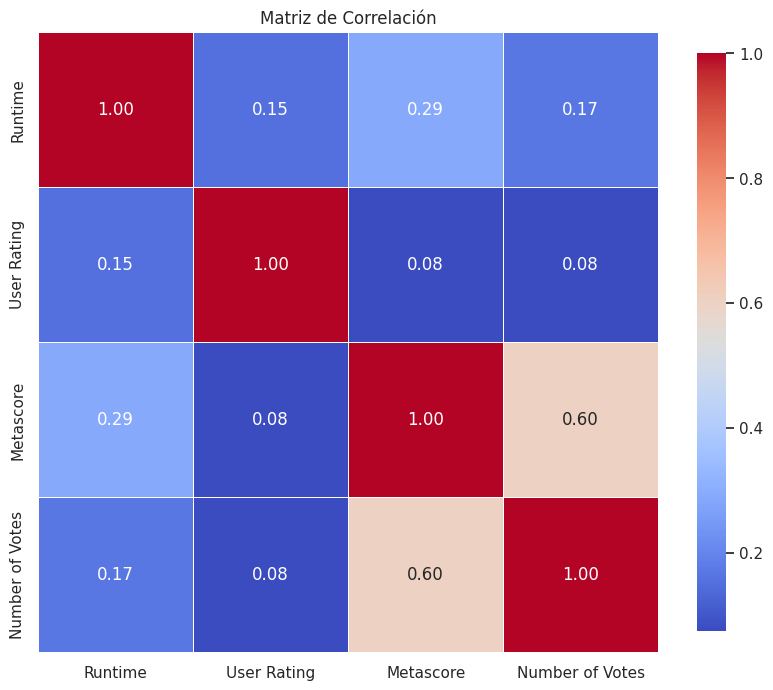

In [24]:
# Crear el heatmap
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True, cbar_kws={"shrink": 0.75})
plt.title('Matriz de Correlación')
plt.show()

Runtime y User Rating:

La correlación entre 'Runtime' y 'User Rating' es de aproximadamente -0.165812, lo que indica una correlación débil negativa. Esto sugiere que, en general, no hay una relación fuerte entre la duración de una obra y la calificación de los usuarios.
Runtime y Number of Votes:

La correlación entre 'Runtime' y 'Number of Votes' es de aproximadamente -0.115130, indicando una correlación débil negativa. Esto sugiere que, en general, la duración de una obra no está fuertemente relacionada con el número de votos.
User Rating y Number of Votes:

La correlación entre 'User Rating' y 'Number of Votes' es de aproximadamente 0.597540, indicando una correlación moderada positiva. Esto sugiere que las obras con calificaciones más altas tienden a recibir más votos.
Metascore:

En las correlaciones proporcionadas, todos los valores relacionados con 'Metascore' son NaN (Not a Number). Esto podría deberse a que todos los valores en la columna 'Metascore' son faltantes o que la desviación estándar de 'Metascore' es cero, lo que lleva a valores indefinidos en las correlaciones.

 Genera una función que resuma todo el procesamiento necesario para el dataset,
que lea el dataset original y entregue un dataset ya tratado, con las columnas
transformadas y creadas

In [27]:
import pandas as pd
import re

def limpiar_dataframe(df):
    # Paso 1
    columns_to_drop = ['Stars','Certificate','Episode','Gross']
    df = df.drop(columns=columns_to_drop)

    # Paso 2
    df['Year'] = df['Year'].astype(str)
    df['Year_start'] = None
    df['Year_end'] = None

    for index, row in df.iterrows():
        if row['Year'].startswith('('):
            years = re.findall(r'\d{4}', row['Year'])
            df.at[index, 'Year_start'] = years[0] if years else None
            df.at[index, 'Year_end'] = years[1] if len(years) > 1 else "2024"
        elif row['Year'].startswith('-'):
            df.at[index, 'Year_start'] = row['Year'][1:]
            df.at[index, 'Year_end'] = row['Year'][1:]
        else:
            df.at[index, 'Year_start'] = row['Year'][1:-3]
            df.at[index, 'Year_end'] = "2023"

    df = df.drop(columns=['Year'])

    # Paso 3
    df['User Rating'] = pd.to_numeric(df['User Rating'], errors='coerce')
    df['Number of Votes'] = pd.to_numeric(df['Number of Votes'], errors='coerce')
    df['Title'] = df['Title'].astype(str)
    df['Year_start'] = df['Year_start'].astype(str)
    df['Genre'] = df['Genre'].astype(str)
    df['Runtime'] = df['Runtime'].astype(str)
    df['Runtime'] = df['Runtime'].str.extract('(\d+)').astype(float)
    df['Metascore'] = pd.to_numeric(df['Metascore'], errors='coerce')
    df['Year_start'] = pd.to_datetime(df['Year_start'], format='%Y', errors='coerce')
    df['Year_end'] = pd.to_datetime(df['Year_end'], format='%Y', errors='coerce')

    # Paso 4
    selected_columns = ['Title', 'Genre', 'Episode Title', 'Runtime', 'User Rating', 'Metascore', 'Number of Votes', 'Year_start', 'Year_end']
    df2 = df[selected_columns].copy()

    # Paso 5
    df2['Episode Title'].fillna('No disponible', inplace=True)
    df2['User Rating'].fillna(1, inplace=True)
    df2['Number of Votes'].fillna(0, inplace=True)
    df2['Runtime'].fillna(df2['Runtime'].mean(), inplace=True)
    df2['Metascore'].fillna(1, inplace=True)
    df2 = df2.dropna(subset=['Year_start'])

    return df2

# Uso de la función con el DataFrame original
df_original = pd.DataFrame({
    'Title': ['One Piece', 'TMNT', 'Super Mario Bros.', 'Attack on Titan'],
    'Genre': ['Animation', 'Action', 'Adventure', 'Animation'],
    'User Rating': [8.9, 7.4, 7.1, 9.1],
    'Number of Votes': [187689, 28895, 189108, 434457],
    'Runtime': ['24 min', '99 min', '92 min', '24 min'],
    'Year': ['(1999– )', '-2023', '-2023', '(2013–2023)'],
    'Summary': ['Summary 1', 'Summary 2', 'Summary 3', 'Summary 4'],
    'Stars': ['Star 1', 'Star 2', 'Star 3', 'Star 4'],
    'Certificate': ['PG', 'PG', 'PG', 'R'],
    'Metascore': [None, 74, 46, None],
    'Gross': [187689, 28895, 189108, 434457],
    'Episode': [0, 0, 0, 0],
    'Episode Title': [None, None, None, None]
})

df_limpio = limpiar_dataframe(df_original)
df_limpio


,Title,Genre,Episode Title,Runtime,User Rating,Metascore,Number of Votes,Year_start,Year_end
0,One Piece,Animation,No disponible,24.0,8.9,1.0,187689,1999-01-01,2024-01-01
1,TMNT,Action,No disponible,99.0,7.4,74.0,28895,2023-01-01,2023-01-01
2,Super Mario Bros.,Adventure,No disponible,92.0,7.1,46.0,189108,2023-01-01,2023-01-01
3,Attack on Titan,Animation,No disponible,24.0,9.1,1.0,434457,2013-01-01,2023-01-01


7. A partir de las columnas que obtuviste realiza una selección de variables según los
siguientes métodos:
a. Filtros basados en correlaciones
b. Forward Selection.
Compara ambos métodos y responde si coincide lo resultante con lo obtenido en el
análisis exploratorio.


In [26]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
df4=df.copy()
# Eliminar columnas no numéricas y sin relevancia
df_numeric = df4[['User Rating', 'Number of Votes', 'Runtime', 'Metascore', 'Gross']]

# Eliminar filas con valores nulos para evitar problemas en el modelo
df_numeric = df_numeric.dropna()

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Imprimir la matriz de correlación
print("Matriz de correlación:")
print(correlation_matrix)

# Método a. Filtros basados en correlaciones
# Seleccionar las variables que tienen una correlación superior a un umbral determinado
threshold = 0.5
high_correlation_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_correlation_vars.add(colname)

print("\nVariables seleccionadas por correlaciones:")
print(high_correlation_vars)

# Método b. Forward Selection
# Dividir los datos en características (X) y variable objetivo (y)
X = df_numeric.drop('User Rating', axis=1)
y = df_numeric['User Rating']

# Crear modelo de regresión (ajustar según tu tipo de análisis)
model = LinearRegression()

# Calcular los p-valores de cada característica usando regresión lineal
f_values, p_values = f_regression(X, y)

# Seleccionar las variables basadas en los p-valores
alpha = 0.05
selected_variables_forward = list(X.columns[p_values < alpha])

print("\nVariables seleccionadas por Forward Selection:")
print(selected_variables_forward)


Matriz de correlación:
                 User Rating  Number of Votes   Runtime  Metascore     Gross
User Rating         1.000000         0.060500 -0.044078   0.010107  0.060500
Number of Votes     0.060500         1.000000  0.166832   0.598403  1.000000
Runtime            -0.044078         0.166832  1.000000   0.296307  0.166832
Metascore           0.010107         0.598403  0.296307   1.000000  0.598403
Gross               0.060500         1.000000  0.166832   0.598403  1.000000

Variables seleccionadas por correlaciones:
{'Gross', 'Metascore'}

Variables seleccionadas por Forward Selection:
['Number of Votes', 'Runtime', 'Gross']


In [28]:
df.shape

(45571, 15)

Analizando las variales escogidas por el fordward son bastante parecidas a las numericas conservadas en el primer analisis, solo que numero de votos y gross son duplicados

In [29]:
selected = df4[['Number of Votes','Gross']]
selected

,Number of Votes,Gross
0,187689.0,187689.0
1,28895.0,28895.0
2,189108.0,189108.0
3,434457.0,434457.0
4,82909.0,82909.0
...,...,...
45712,3432.0,3432.0
45713,3309.0,3309.0
45714,2743.0,2743.0
45715,0.0,NaN
